# Importing Libraries

In [22]:
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pathlib
import random
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
path = 'C:\\Users\\Lenvo\Desktop\BreasCancerimages'
data_dir = pathlib.Path(path)

In [24]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['benign', 'malignant', 'normal'], dtype='<U9')

In [25]:
benignPath = os.path.join(data_dir, 'bening')
malignantPath = os.path.join(data_dir,'malignant')
normalPath = os.path.join(data_dir,'normal')


In [26]:
imageCount = len(list(data_dir.glob('*/*.png')))
imageCount

1578

# Images Preprocessing

In [28]:
# Constants
img_height = 100
img_width = 100
batch_size = 32

In [69]:
# Enhancing images
def preprocess(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)
    return img


In [70]:
# Load, preprocess, and resize images
def load_preprocess_resize(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = preprocess(img)
    img = cv2.resize(img, (img_width, img_height))
    img1 = image.load_img(filepath, target_size=(img_height, img_width))
    img1 = image.img_to_array(img1)
    return img

In [71]:
# Load and preprocess images in batches
def load_and_preprocess_batch(filepaths):
    return [load_preprocess_resize(str(img_path)) for img_path in filepaths]



In [72]:
# Load and preprocess images for each class
benign_images = load_and_preprocess_batch(list(data_dir.glob('benign/*.png')))
malignant_images = load_and_preprocess_batch(list(data_dir.glob('malignant/*.png')))
normal_images = load_and_preprocess_batch(list(data_dir.glob('normal/*.png')))

In [73]:
# Convert images to NumPy array
benign_images = np.array(benign_images, dtype=np.float32)
malignant_images = np.array(malignant_images, dtype=np.float32)
normal_images = np.array(normal_images, dtype=np.float32)

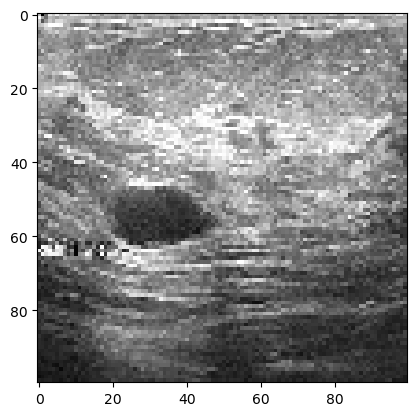

In [74]:
# Testing with an example image
testing = 'C:\\Users\\Lenvo\Desktop\\BreasCancerimages\\benign\\benign (2).png'
img1 = load_preprocess_resize(testing)
plt.imshow(img1)

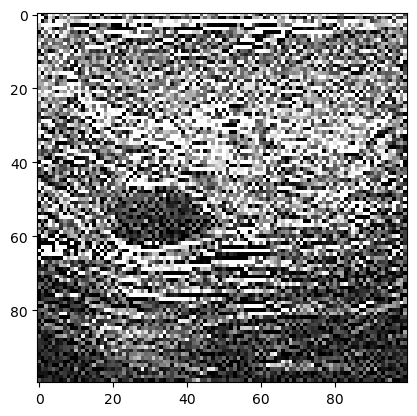

In [75]:
img1=preprocess(img1)
# Sharpened Image
plt.imshow(img1)

# Randomly plotting images

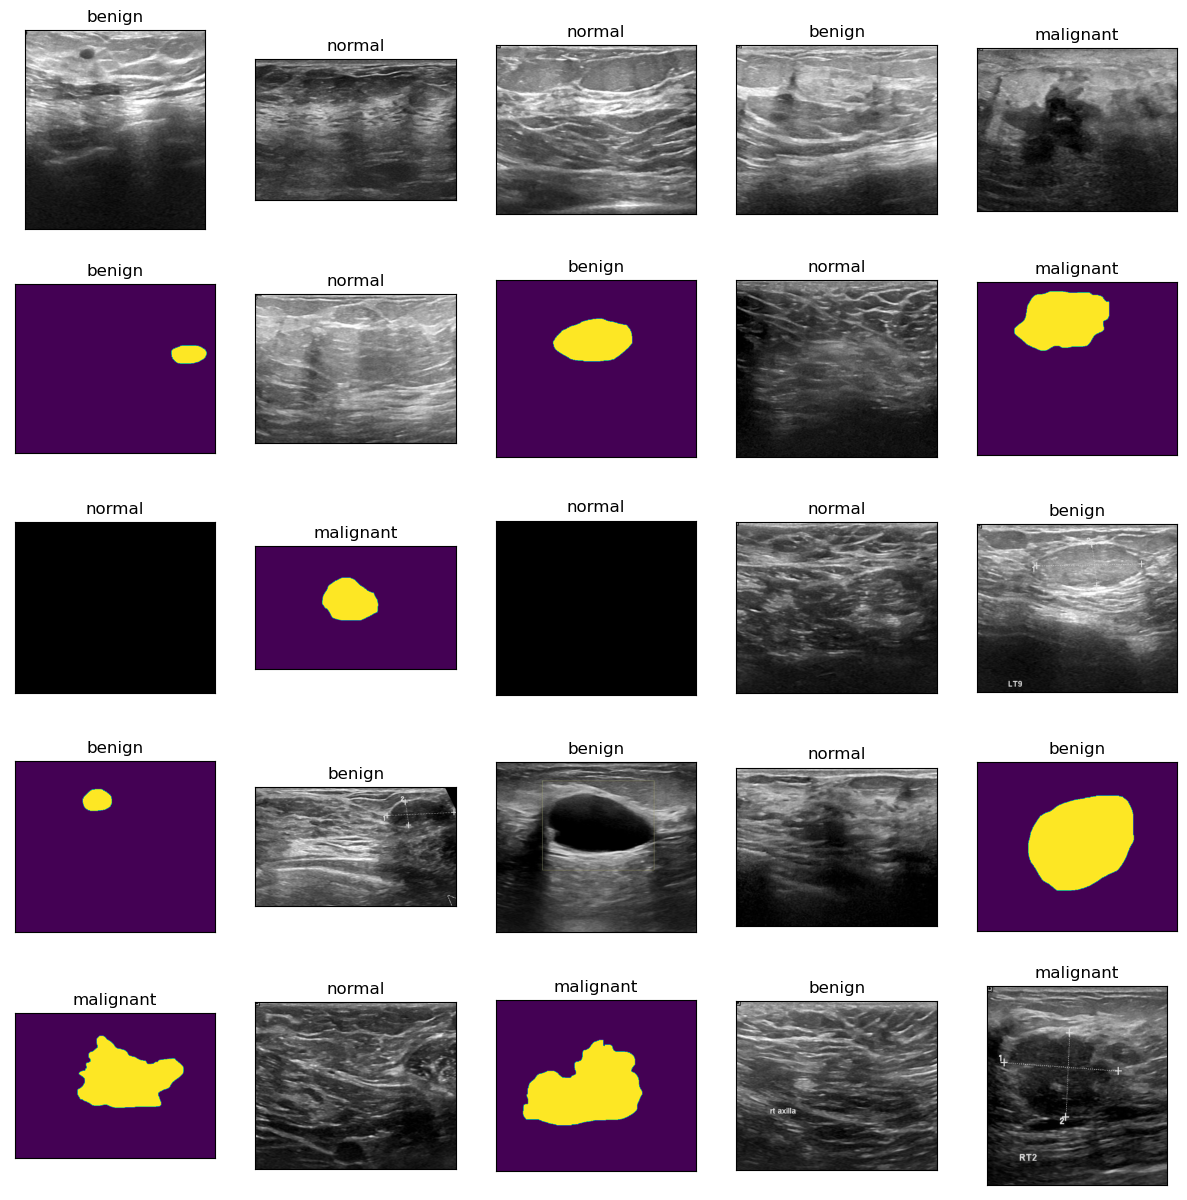

In [167]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    random_class = random.choice(class_names)
    img = plt.imread(random.choice(list(data_dir.glob(random_class+"/*.png"))))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)
    plt.imshow(img)

In [77]:
# Checking image formats

from pathlib import Path
import imghdr

data_dir = 'C:\\Users\\Lenvo\Desktop\\BreasCancerimages'
image_extensions = [".png", ".jpg"]  

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

# Data splitting and processing

In [168]:
# Data directory
path = 'C:\\Users\\Lenvo\Desktop\BreasCancerimages'
data_dir = pathlib.Path(path)

# Paths for each class
benignPath = os.path.join(data_dir, 'benign')
malignantPath = os.path.join(data_dir, 'malignant')
normalPath = os.path.join(data_dir, 'normal')


In [169]:
# Data Splitting
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_data = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 1578 files belonging to 3 classes.
Using 1263 files for training.
Found 1578 files belonging to 3 classes.
Using 315 files for validation.


# Define the model

In [8]:
def build_model(learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(dropout_rate),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(2, activation='softmax')  # Assuming binary classification for pneumonia
    ])
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [29]:
# Hyperparameter tuning
param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'dropout_rate': [0.3, 0.5, 0.7]}
param_combinations = list(ParameterGrid(param_grid))

param_combinations = list(ParameterGrid(param_grid))
train_data_for_tuning = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_data_for_tuning = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1578 files belonging to 3 classes.
Using 1263 files for training.
Found 1578 files belonging to 3 classes.
Using 315 files for validation.


In [143]:

# Hyperparameter tuning
param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'dropout_rate': [0.3, 0.5, 0.7]}
param_combinations = list(ParameterGrid(param_grid))

best_accuracy = 0.0
best_model = None

for params in param_combinations:
    model = build_model(learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

    _, accuracy = model.evaluate(val_data)
    print(f'Learning Rate: {params["learning_rate"]}, Dropout Rate: {params["dropout_rate"]}, Accuracy: {accuracy}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model



Epoch 1/30
40/40 [==============================] - 15s 284ms/step - loss: 499.9241 - accuracy: 0.5139 - val_loss: 1138.6484 - val_accuracy: 0.5016
Epoch 2/30
40/40 [==============================] - 11s 266ms/step - loss: 1.0130 - accuracy: 0.5954 - val_loss: 38.7000 - val_accuracy: 0.4190
Epoch 3/30
40/40 [==============================] - 11s 266ms/step - loss: 0.9608 - accuracy: 0.5891 - val_loss: 11.2546 - val_accuracy: 0.4413
Epoch 4/30
40/40 [==============================] - 11s 270ms/step - loss: 0.9873 - accuracy: 0.5637 - val_loss: 1.0015 - val_accuracy: 0.5746
Epoch 5/30
40/40 [==============================] - 11s 268ms/step - loss: 0.9837 - accuracy: 0.5629 - val_loss: 0.9757 - val_accuracy: 0.5714
Epoch 6/30
40/40 [==============================] - 11s 267ms/step - loss: 0.9777 - accuracy: 0.5645 - val_loss: 0.9752 - val_accuracy: 0.5714
Epoch 7/30
40/40 [==============================] - 12s 277ms/step - loss: 0.9800 - accuracy: 0.5653 - val_loss: 0.9842 - val_accuracy:

In [144]:
# Evaluate the best model on validation data
_, accuracy = best_model.evaluate(val_data)
print(f'Best Model - Accuracy: {accuracy}')

# Display the best model summary
best_model.summary()

# Save the best model
best_model.save('best_cancer_model.h5')
print('Best Model Saved Successfully!')

10/10 [==============================] - 1s 40ms/step - loss: 0.6761 - accuracy: 0.8032
Best Model - Accuracy: 0.803174614906311
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_135 (Conv2D)         (None, 100, 100, 32)      896       
                                                                 
 batch_normalization_135 (B  (None, 100, 100, 32)      128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_135 (MaxPool  (None, 50, 50, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_136 (Conv2D)         (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_136 (B  (None, 50, 50, 64)        2

1/1 [==============================] - 0s 52ms/step


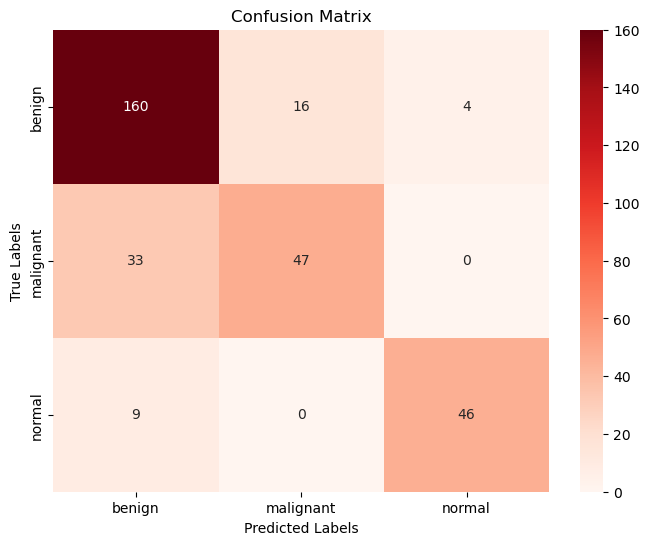

In [165]:
# Generate predictions for confusion matrix
y_true = []
y_pred = []
for images, labels in val_data:
    predictions = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [151]:
# Classification Report
print("Classification Report:")
classification_rep = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
for class_name, metrics in classification_rep.items():
    if class_name == 'accuracy':
        print("\nClass: accuracy")
        print(f"Accuracy: {metrics:.4f}")
    else:
        print(f"\nClass: {class_name}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1-score']:.4f}")
        print(f"Support: {metrics['support']}")
        print("-" * 40)

# Overall Accuracy
accuracy = classification_rep['accuracy']
print(f"\nOverall Accuracy: {accuracy:.4f}")

Classification Report:

Class: benign
Precision: 0.7921
Recall: 0.8889
F1-score: 0.8377
Support: 180
----------------------------------------

Class: malignant
Precision: 0.7460
Recall: 0.5875
F1-score: 0.6573
Support: 80
----------------------------------------

Class: normal
Precision: 0.9200
Recall: 0.8364
F1-score: 0.8762
Support: 55
----------------------------------------

Class: accuracy
Accuracy: 0.8032

Class: macro avg
Precision: 0.8194
Recall: 0.7709
F1-score: 0.7904
Support: 315
----------------------------------------

Class: weighted avg
Precision: 0.8027
Recall: 0.8032
F1-score: 0.7986
Support: 315
----------------------------------------

Overall Accuracy: 0.8032


# Accuracy vs Loss

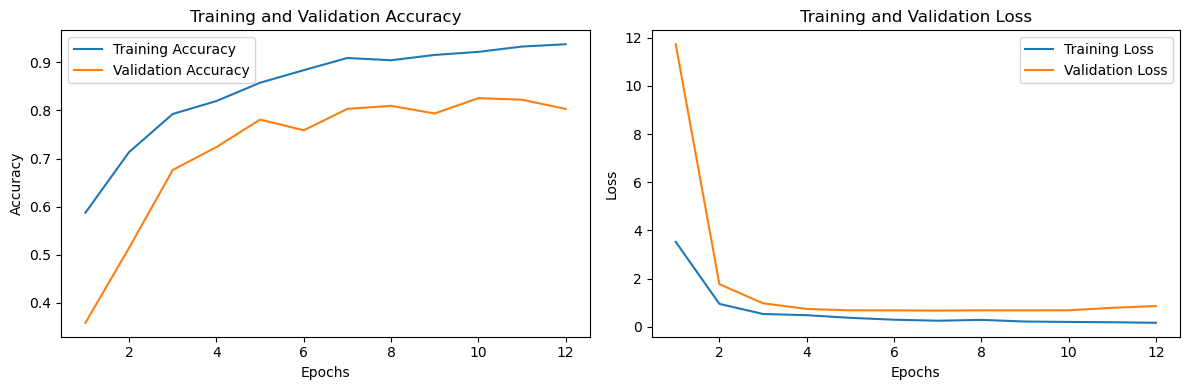

In [153]:
# Extracting accuracy, validation accuracy, loss, and validation loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generating the range of epochs
epochs_range = range(1, len(acc) + 1)  # Use len(acc) to get the correct number of epochs

# Plotting accuracy and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


# Model Evaluation

In [154]:
# Evaluating
model.evaluate(val_data)

10/10 [==============================] - 1s 39ms/step - loss: 0.6761 - accuracy: 0.8032


[0.6760971546173096, 0.803174614906311]

In [155]:
from tensorflow.keras.utils import load_img
img1=load_img(testing)
img1=img1.resize((img_height, img_width))
input_arr = tf.keras.preprocessing.image.img_to_array(img1)
img = input_arr.reshape( -1,100, 100,3)
img.shape


(1, 100, 100, 3)

In [156]:
# Predicting the model
res=np.array(savedModel.predict(img))
print(res)
if(max(res[0])==res[0][0]):
    print("Benign")
elif(max(res[0])==res[1][1]):
    print("Malignant")
else:
    print("Normal")

1/1 [==============================] - 0s 72ms/step
[[9.994979e-01 5.014877e-04 6.035246e-07]]
Benign


# Predictions

1/1 [==============================] - 0s 20ms/step


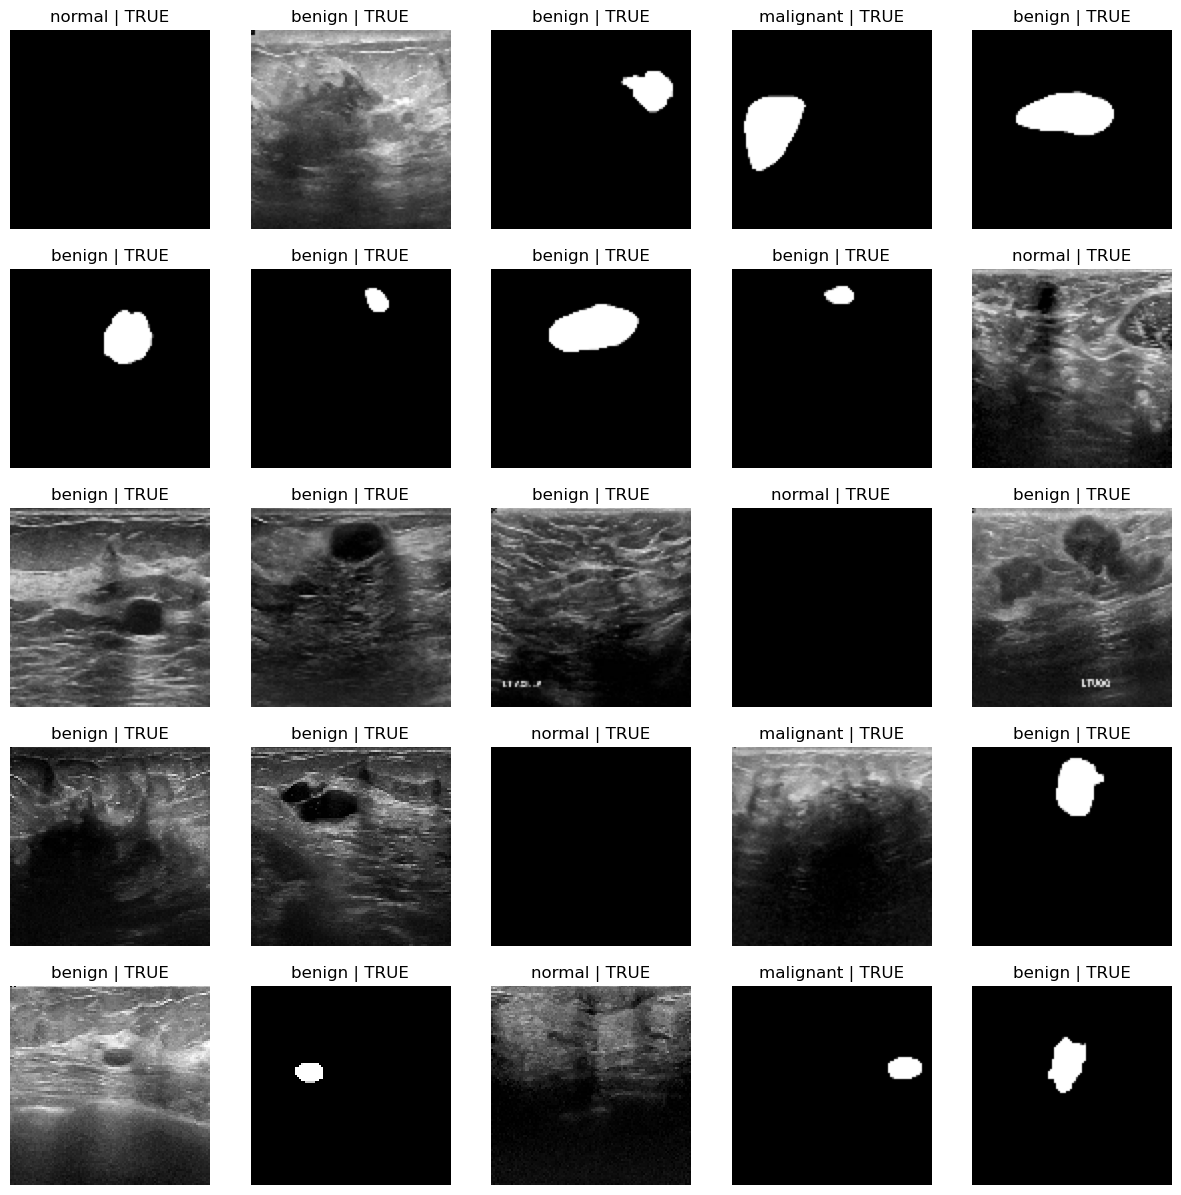

In [157]:
plt.figure(figsize=(15, 15))
class_names = val_data.class_names
result = ' | False'
for images, labels in val_data.take(1):
    for i in range(25):
        
        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        
        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'
            
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result  )
        plt.axis("off")

# Test with a random Image 1

1/1 [==============================] - 0s 101ms/step
True Class: tests
Predicted Class: benign


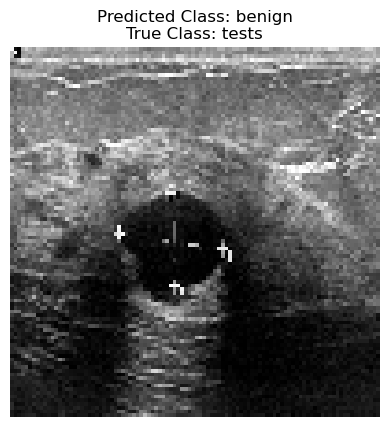

In [163]:
#saved model
model = models.load_model('best_cancer_model.h5')

def load_and_preprocess_single_image(filepath):
    img = load_preprocess_resize(filepath)
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension
    return img_array, img

test_image_path = 'C:\\Users\\Lenvo\\Desktop\\tests\\1.png'
test_image, original_image = load_and_preprocess_single_image(test_image_path)

# Make predictions
predictions = model.predict(test_image)

# Get the class index with the highest probability
predicted_class_index = np.argmax(predictions)

# Map the index to the corresponding class name
predicted_class = class_names[predicted_class_index]

# Get true class name from the file path
true_class = test_image_path.split('\\')[-2]

# Check if the prediction is correct
correct_prediction = predicted_class == true_class

# Display the result
print(f'True Class: {true_class}')
print(f'Predicted Class: {predicted_class}')


# Display the image and prediction
plt.imshow(original_image)
plt.title(f'Predicted Class: {predicted_class}\nTrue Class: {true_class}')
plt.axis('off')
plt.show()